In [2]:

import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.lite.python.lite
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib


Defining the dataset path

In [3]:
print(os.listdir('dataset/squat'))

['test', 'train', 'validation']


In [4]:
#global variables
squat_folder = Path('dataset/squat')
train_folder = squat_folder/'train'
test_folder = squat_folder/'test'
validation_folder = squat_folder/'validation'
exercise_name = 'squat'


Get the stages of the exercise

In [5]:
labels = os.listdir(train_folder)
print(labels)

['down', 'up']


Prepare the training data

In [6]:
def load_training_data():
    up_pos = train_folder / 'up'
    down_pos = train_folder / 'down'
    train_data = []
    train_labels = []
    # glob is used to serch for files that mtch a specific patters
    up_pos_folder = up_pos.glob('*.jpg') #find all jpg images
    down_pos_folder = down_pos.glob('*.jpg')

    #append to the array the images for up position
    for img in up_pos_folder:
        train_data.append(img)
        train_labels.append('up')

    #append images for down positions
    for img in down_pos_folder:
        train_data.append(img)
        train_labels.append('down')

    #create data frame with the data
    train_df = pd.DataFrame(train_data, columns=['images'])

    train_df['labels'] = train_labels
    train_df = train_df.sample(frac = 1).reset_index(drop=True)

    return train_df

Call the function for loading the data

In [7]:
# create the training dataframe
train_data = load_training_data()
train_data.shape #see rows and columns -> we have 169 images therefore 169 rows and 2 cols

(169, 2)

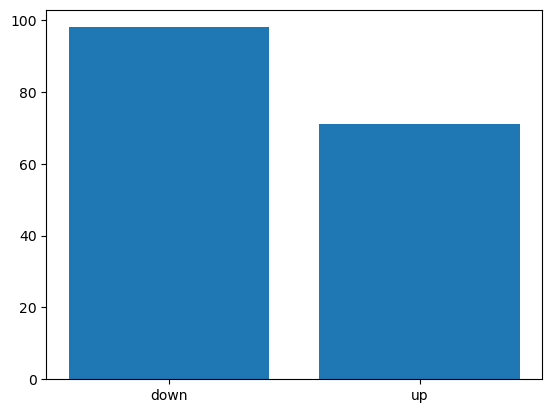

In [8]:
plt.bar(train_data['labels'].value_counts().index, train_data['labels'].value_counts().values)
plt.show(plt)

In [9]:
def plot(image_batch, label_batch):
    plt.figure(figsize=(10,5))
    for i in range(10):
            ax = plt.subplot(2,5, i + 1)
            img = cv2.imread(str(image_batch[i]))
            img = cv2.resize(img, (224, 224))
            plt.imshow(img)
            plt.title(label_batch[i])
            plt.axis('off')

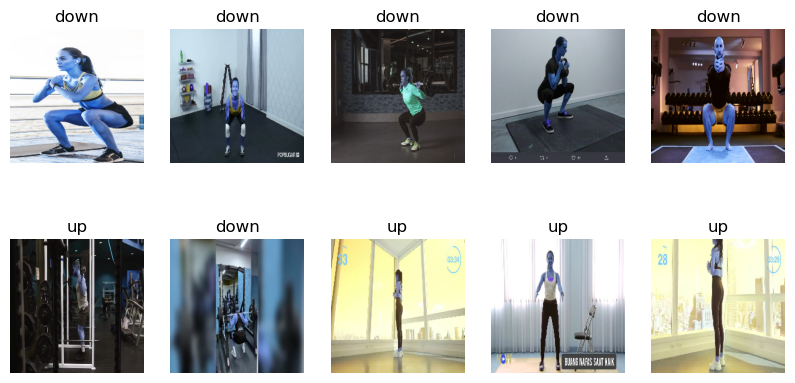

In [10]:
image_batch = train_data['images']
label_batch = train_data['labels']
plot(image_batch, label_batch)

Data Pre-Processing

In [11]:
#resize  to 224,224,3
#resize  to 224,224,3
def prepare_and_load(isVal = True):
    # choosing the validation folder or the train folder to load the data from
    if isVal==True:
        up_dir = validation_folder/'up'
        down_dir = validation_folder/'down'
    else:
        up_dir = test_folder/'up'
        down_dir = test_folder/'down'
    squats_up = up_dir.glob("*.jpg")
    squats_down = down_dir.glob("*.jpg")

    data, squat_labels = ([] for x in range(2))

    def prepare(case):
        # case  = folder
        for img in case:
            img = cv2.imread(str(img))
            if img is None:
                continue
            img = cv2.resize(img, (224, 224))
            if(img.shape[2] == 1):
                img = np.dstack(img, cv2.COLOR_BGRB2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255
            if case == squats_up:
                #to_categorical is used to convert labels to one-hot encoded format.
                label = to_categorical(0, num_classes=2)
            else:
                label = to_categorical(1, num_classes=2)
            data.append(img)
            squat_labels.append(label)
        return data,squat_labels
    prepare(squats_up)
    d,l = prepare(squats_down)
    d = np.array(d)
    l = np.array(l)
    return d,l

In [12]:
val_data, val_labels = prepare_and_load(isVal=True)
test_data, test_labels = prepare_and_load(isVal=False)
print('Number of test images =>',len(test_data))
print('Number of validation images => ', len(val_data))

Number of test images => 28
Number of validation images =>  18


In [13]:

def checkForBrokenImages(folder):
    count = 0
    for file in folder:
        try:
            img =  cv2.imread(str(file))
            img = cv2.resize(img, (224, 224))
        except (Exception) as e:
            count+=1
            print("Bad img: ", file.name)
    return count

In [14]:
squats_up = (validation_folder/'down').glob("*.jpg")
no = checkForBrokenImages(squats_up)
print(no)

0


In [15]:
#aining takes place in batches. The model takes the first batch, passes it through the network, a loss is calculated in the end, then the gradients travel backward to update the parameters of the network. This process is repeated until we reach our desired loss and training stops.
# We’ll now write a function to generate images in batches from the train set.

def data_gen(data, size_batch):
    n = len(data)
    steps = n // size_batch
    #define two arrays for containing batch dta and labels
    batch_data = np.zeros((size_batch, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((size_batch, 2), dtype=np.float32)
    indices = np.arange(n)
    i = 0

    while True:
        np.random.shuffle(indices)
        count = 0
        next_batch = indices[(i * size_batch):(i + 1) * size_batch]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['images']

            label = data.iloc[idx]['labels']
            if label == 'up':
                label = 0
            else:
                label = 1

            encoded_label = to_categorical(label, num_classes=2)

            img = cv2.imread(str(img_name))
            if img is None:
                continue
            img = cv2.resize(img, (224, 224))

            if img.shape[2]==1:
                img = np.dstack([img, img, img])

            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            orig_img = img.astype(np.float32)/255

            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            count += 1
            if count == size_batch - 1:
                break

        i += 1
        yield  batch_data, batch_labels

        if i>= steps:
            i = 0

Create the mdoel

In [16]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(224, 224,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Dense(2))
model.add(Activation('softmax'))

In [17]:
batch_size = 20
nb_epochs = 10

train_data_gen = data_gen(data = train_data, size_batch=batch_size)

nb_train_steps = train_data.shape[0]//batch_size
print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(val_data)))

Number of training and validation steps: 8 and 18


It is quite evident that our validation accuracy is not that good. There are a number of tricks that you can use to get good performance.

Change the batch size.
Train for more epochs.
Use a different optimizer.
Tweak the neural network by adding/ removing layers.

In [18]:
# train_data_gen  = tf.stack(train_data_gen)

model.compile(loss = 'binary_crossentropy',
              optimizer='rmsprop',
              metrics = ['accuracy'])
history = model.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps, validation_data=(val_data, val_labels))

Epoch 1/10
8/8 [==============================] - 6s 718ms/step - loss: 2.0492 - accuracy: 0.5250 - val_loss: 0.6431 - val_accuracy: 0.6111
Epoch 2/10
8/8 [==============================] - 7s 838ms/step - loss: 0.6145 - accuracy: 0.6438 - val_loss: 0.6353 - val_accuracy: 0.6111
Epoch 3/10
8/8 [==============================] - 5s 577ms/step - loss: 0.6003 - accuracy: 0.6938 - val_loss: 0.6705 - val_accuracy: 0.6111
Epoch 4/10
8/8 [==============================] - 5s 658ms/step - loss: 0.5357 - accuracy: 0.7563 - val_loss: 0.6358 - val_accuracy: 0.7778
Epoch 5/10
8/8 [==============================] - 6s 681ms/step - loss: 0.4767 - accuracy: 0.8188 - val_loss: 0.7754 - val_accuracy: 0.3889
Epoch 6/10
8/8 [==============================] - 6s 755ms/step - loss: 0.3569 - accuracy: 0.8375 - val_loss: 0.5847 - val_accuracy: 0.6111
Epoch 7/10
8/8 [==============================] - 5s 638ms/step - loss: 0.3547 - accuracy: 0.8562 - val_loss: 0.5406 - val_accuracy: 0.7778
Epoch 8/10
8/8 [====

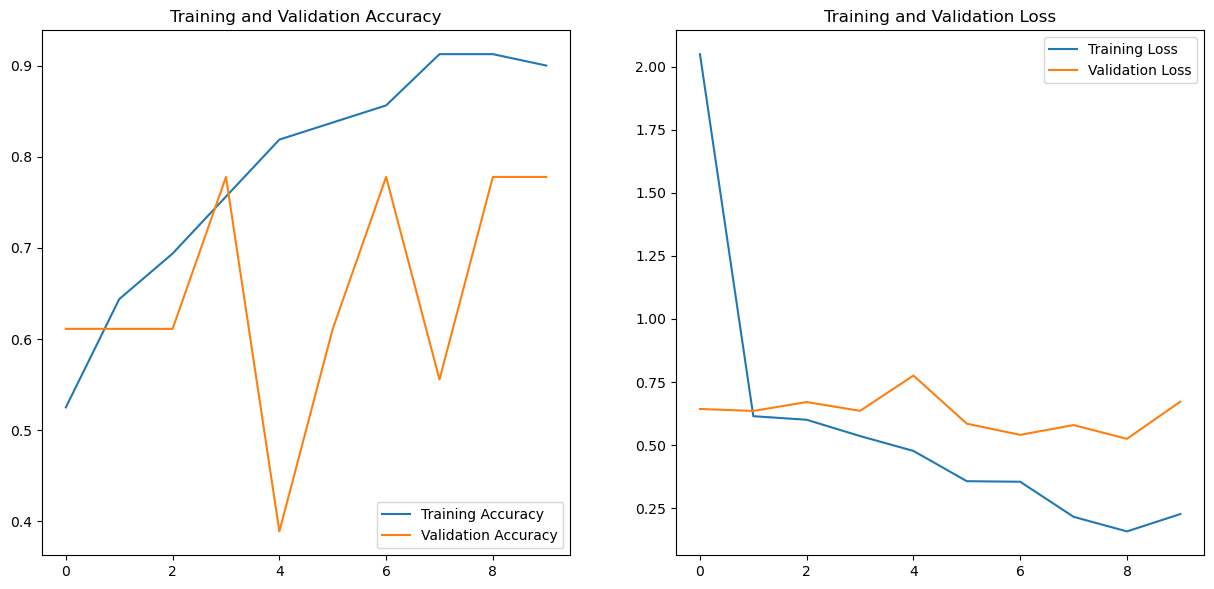

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(nb_epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:


def vgg16_model (num_classes = None):
    m = VGG16(weights = 'imagenet', include_top  = True, input_shape=(224,224,3))
    x = Dense(1024, activation = 'relu')(m.layers[-4].output) #adding my own dense layer after the last conv block
    x = Dropout(0.7)(x)
    x = Dense(512, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation = 'softmax')(x)
    m = Model(m.input, x)
    return m


In [21]:
vgg_conv = vgg16_model(2)
for layer in vgg_conv.layers[:-5]: #freeze all layers except the last ten
    layer.trainable = False

In [22]:
opt = Adam(learning_rate = 0.0001, decay=1e-5)
vgg_conv.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = opt)

In [23]:
history = vgg_conv.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps, validation_data=(val_data, val_labels), class_weight={0:1.0,1:0.4})


Epoch 1/10
8/8 [==============================] - 22s 3s/step - loss: 0.6092 - accuracy: 0.5000 - val_loss: 0.9438 - val_accuracy: 0.3889
Epoch 2/10
8/8 [==============================] - 21s 3s/step - loss: 0.4445 - accuracy: 0.6000 - val_loss: 0.4877 - val_accuracy: 0.7778
Epoch 3/10
8/8 [==============================] - 26s 3s/step - loss: 0.4124 - accuracy: 0.7250 - val_loss: 0.4569 - val_accuracy: 0.7778
Epoch 4/10
8/8 [==============================] - 28s 3s/step - loss: 0.3590 - accuracy: 0.7375 - val_loss: 0.4552 - val_accuracy: 0.8333
Epoch 5/10
8/8 [==============================] - 27s 3s/step - loss: 0.3780 - accuracy: 0.6875 - val_loss: 0.3791 - val_accuracy: 1.0000
Epoch 6/10
8/8 [==============================] - 26s 3s/step - loss: 0.2811 - accuracy: 0.7750 - val_loss: 0.3694 - val_accuracy: 0.9444
Epoch 7/10
8/8 [==============================] - 22s 3s/step - loss: 0.1955 - accuracy: 0.8500 - val_loss: 0.4858 - val_accuracy: 0.6111
Epoch 8/10
8/8 [==================

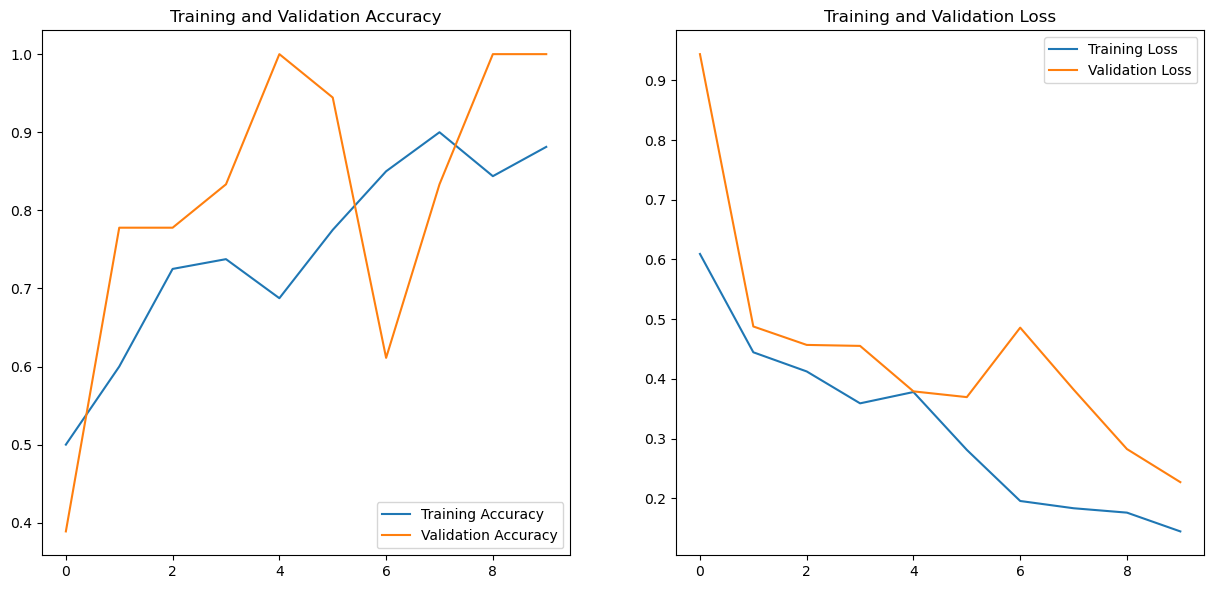

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(nb_epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
loss, acc = vgg_conv.evaluate(test_data, test_labels, batch_size=16)
print('Loss and accuracy', loss, '&', acc)

2/2 [==============================] - 4s 2s/step - loss: 0.3762 - accuracy: 0.8214
Loss and accuracy 0.3762240409851074 & 0.8214285969734192


In [26]:
###################
pred = vgg_conv.predict(test_data, batch_size= 16)
pred = np.argmax(pred, axis = -1)
labels = np.argmax(test_labels, axis = -1)
from sklearn.metrics import classification_report
print(classification_report(labels, pred))

2/2 [==============================] - 4s 2s/step
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        20
           1       0.67      0.75      0.71         8

    accuracy                           0.82        28
   macro avg       0.78      0.80      0.79        28
weighted avg       0.83      0.82      0.82        28



In [27]:
#save the model object
tf.keras.models.save_model(vgg_conv, 'model.pbtxt')

#we have to convert it to a tensorflow lite converter object
#the function will take the model and the pbtx
converter = tf.lite.TFLiteConverter.from_keras_model(model = vgg_conv)
model_tflite = converter.convert()

#save the model to tensofrlow lite file
open("personal_trainer_model.tflite", "wb").write(model_tflite)

INFO:tensorflow:Assets written to: model.pbtxt\assets


INFO:tensorflow:Assets written to: model.pbtxt\assets


INFO:tensorflow:Assets written to: C:\Users\Diana\AppData\Local\Temp\tmpgh837r9w\assets


INFO:tensorflow:Assets written to: C:\Users\Diana\AppData\Local\Temp\tmpgh837r9w\assets


163736348

In [28]:
from keras_preprocessing.image import load_img
image_name = "test.jpg"
image = load_img(image_name, target_size=(224, 224))
img = np.array(image)
img = img / 255.0
img = img.reshape(1,224,224,3)
label = vgg_conv.predict(img)
print("Predicted Class (0 - Down , 1-  Up): ", label[0][0])


1/1 [==============================] - 0s 182ms/step
Predicted Class (0 - Down , 1-  Up):  0.015682818


In [29]:
label.shape

(1, 2)

In [30]:
print(tf. __version__)

2.10.1
